In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([500, 500], dtype=int64))

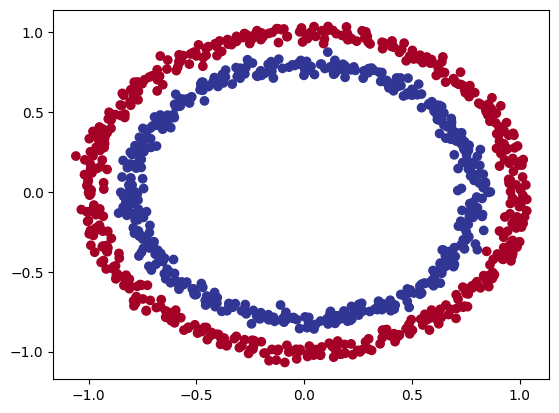

In [4]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X, y

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         ...,
         [-0.1369, -0.8100],
         [ 0.6704, -0.7675],
         [ 0.2811,  0.9638]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
class classificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_one = nn.Linear(in_features=2, out_features=10)
        self.linear_two = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.linear_two(self.linear_one(x))
    
model = classificationModel().to(device)

In [20]:
model.state_dict()

OrderedDict([('linear_one.weight',
              tensor([[ 0.1254,  0.1859],
                      [ 0.3758, -0.3205],
                      [-0.3316,  0.3692],
                      [ 0.1403, -0.5997],
                      [ 0.5139,  0.3053]], device='cuda:0')),
             ('linear_one.bias',
              tensor([ 0.4310,  0.6374, -0.5523, -0.6316,  0.2356], device='cuda:0')),
             ('linear_two.weight',
              tensor([[ 0.3506,  0.1936, -0.4162, -0.2043, -0.0633]], device='cuda:0')),
             ('linear_two.bias', tensor([0.3544], device='cuda:0'))])

In [34]:
# Make predictions with the model
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0181],
        [ 0.0556],
        [-0.0574],
        [-0.0076],
        [ 0.1869],
        [ 0.2300],
        [ 0.2439],
        [ 0.2853],
        [-0.0677],
        [ 0.0633]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [49]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)

In [13]:
# Accuracy metric
def calc_accuracy(y_pred, actual_val):
    correct = torch.eq(y_pred, actual_val).sum()
    acc = (correct / len(y_pred)) * 100
    return acc

In [36]:
y_logits = model(X_test[:5].to(device))
y_logits

tensor([[-0.0181],
        [ 0.0556],
        [-0.0574],
        [-0.0076],
        [ 0.1869]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4955],
        [0.5139],
        [0.4857],
        [0.4981],
        [0.5466]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [2]:
epochs = 100
torch.manual_seed(1234)

accuracy = []
test_losses = []

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = calc_accuracy(y_pred, y_train)

    loss.backward()

    optimizer.step()

    # Evaluate
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_loss = loss_fn(test_logits, y_test)

        test_pred = torch.round(torch.sigmoid(test_logits))

        test_acc = calc_accuracy(test_pred, y_test)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} finished with {acc} train acc, {loss} train loss, {test_acc} test acc and {test_loss} loss")

NameError: name 'device' is not defined

In [30]:
# from https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

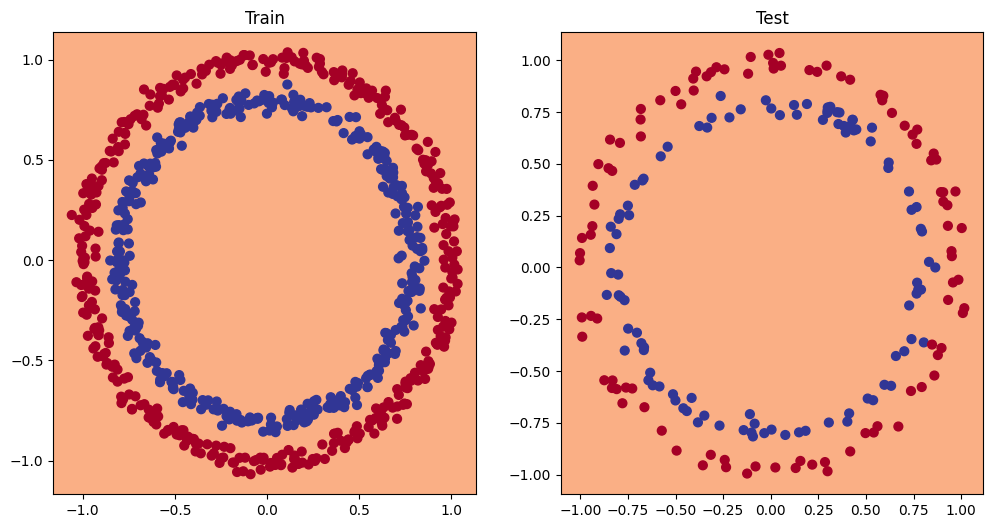

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

# Model 2 With non linearlity

In [53]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_one = nn.Linear(in_features=2, out_features=10)
        self.linear_two = nn.Linear(in_features=10, out_features=5)
        self.linear_three = nn.Linear(in_features=5, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear_one(x)
        x = self.linear_two(x)
        x = self.relu(x)
        return self.linear_three(x)

In [54]:
model_2 = Model2().to(device)
model_2

Model2(
  (linear_one): Linear(in_features=2, out_features=10, bias=True)
  (linear_two): Linear(in_features=10, out_features=5, bias=True)
  (linear_three): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
loss_2 = nn.BCEWithLogitsLoss()

optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=1e-3)

In [59]:
epochs = 1000
torch.manual_seed(1234)


for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_2(y_logits, y_train)

    acc = calc_accuracy(y_pred, y_train)

    loss.backward()
    optimizer_2.step()

    #eval
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_loss = loss_2(test_logits, y_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = calc_accuracy(test_pred, y_test)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} finished with {acc} train acc, {loss} train loss, {test_acc} test acc and {test_loss} loss")

Epoch 0 finished with 56.75 train acc, 0.6926351189613342 train loss, 52.499996185302734 test acc and 0.6978029608726501 loss
Epoch 100 finished with 53.375 train acc, 0.6895886063575745 train loss, 47.0 test acc and 0.694934070110321 loss
Epoch 200 finished with 52.749996185302734 train acc, 0.6875897645950317 train loss, 46.5 test acc and 0.6931678652763367 loss
Epoch 300 finished with 55.25 train acc, 0.6834585666656494 train loss, 50.0 test acc and 0.689940869808197 loss
Epoch 400 finished with 57.875 train acc, 0.6774513125419617 train loss, 56.5 test acc and 0.6946736574172974 loss
Epoch 500 finished with 61.75 train acc, 0.6687292456626892 train loss, 58.0 test acc and 0.6857780814170837 loss
Epoch 600 finished with 58.875 train acc, 0.6561271548271179 train loss, 52.0 test acc and 0.6761932373046875 loss
Epoch 700 finished with 57.5 train acc, 0.6435850262641907 train loss, 52.499996185302734 test acc and 0.6625984311103821 loss
Epoch 800 finished with 63.75 train acc, 0.630662

In [60]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

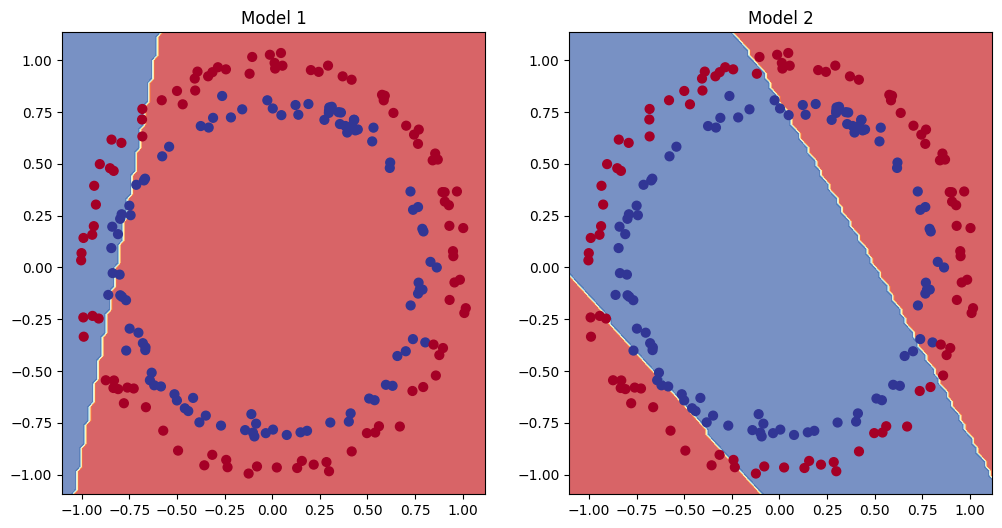

In [63]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Model 1")
plot_decision_boundary(model, X_test, y_test) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Model 2")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

# Multi Class Classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


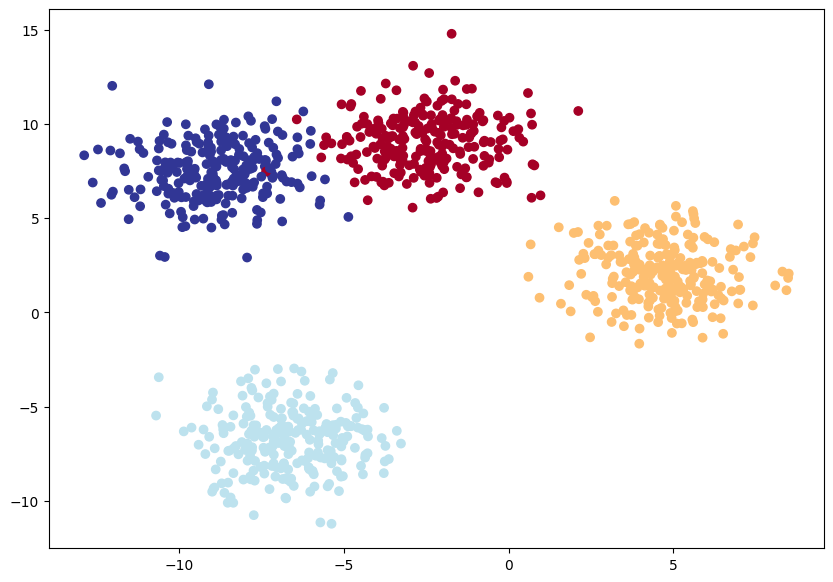

In [64]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [88]:
class ModelMultiClassification(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear_one = nn.Linear(in_features=num_features, out_features=128)
        self.linear_two = nn.Linear(in_features=128, out_features=64)
        self.linear_three = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.linear_one(x)
        x = self.linear_two(x)
        return self.linear_three(x)
    
model_multi = ModelMultiClassification(NUM_FEATURES, NUM_CLASSES).to(device)
model_multi

ModelMultiClassification(
  (linear_one): Linear(in_features=2, out_features=128, bias=True)
  (linear_two): Linear(in_features=128, out_features=64, bias=True)
  (linear_three): Linear(in_features=64, out_features=4, bias=True)
)

In [89]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_multi.parameters(), lr=1e-3)

In [80]:
pred = torch.softmax(model_multi(X_blob_test.to(device)[:5]), dim=1)
pred

tensor([[0.5975, 0.0588, 0.1542, 0.1895],
        [0.1064, 0.2837, 0.2429, 0.3671],
        [0.1352, 0.3117, 0.3036, 0.2495],
        [0.4327, 0.1118, 0.2123, 0.2432],
        [0.5451, 0.0971, 0.1690, 0.1887]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [82]:
torch.argmax(pred, dim=1)

tensor([0, 3, 1, 0, 0], device='cuda:0')

In [90]:
epochs = 1000

X_train, X_test, y_train, y_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_multi.train()

    logits = model_multi(X_train)

    loss = loss_fn(logits, y_train)
    y_pred = torch.argmax(torch.softmax(logits, dim=1), dim =  1)
    acc = calc_accuracy(y_pred, y_train)

    loss.backward()
    optimizer.step()

    model_multi.eval()
    with torch.inference_mode():
        logits_test = model_multi(X_test).squeeze()
        loss_test = loss_fn(logits_test, y_test)
        y_pred_test = torch.argmax(torch.softmax(logits_test, dim=1), dim=1)
        acc_test = calc_accuracy(y_pred_test, y_test)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} finished with {acc} train acc, {loss} train loss, {acc_test} test acc, {loss_test} test loss")

Epoch 0 finished with 11.25 train acc, 2.653099775314331 train loss, 19.999998092651367 test acc, 1.5970425605773926 test loss
Epoch 100 finished with 97.5 train acc, 0.26413285732269287 train loss, 97.5 test acc, 0.3520037531852722 test loss
Epoch 200 finished with 88.25 train acc, 4.244969844818115 train loss, 93.5 test acc, 1.9520701169967651 test loss
Epoch 300 finished with 68.625 train acc, 38.38566589355469 train loss, 70.5 test acc, 32.075653076171875 test loss
Epoch 400 finished with 85.375 train acc, 20.370346069335938 train loss, 89.0 test acc, 11.403368949890137 test loss
Epoch 500 finished with 89.0 train acc, 20.78326988220215 train loss, 86.5 test acc, 28.005449295043945 test loss
Epoch 600 finished with 90.375 train acc, 25.640905380249023 train loss, 93.0 test acc, 14.402849197387695 test loss
Epoch 700 finished with 74.0 train acc, 340.61004638671875 train loss, 75.0 test acc, 305.14385986328125 test loss
Epoch 800 finished with 96.0 train acc, 19.493139266967773 trai

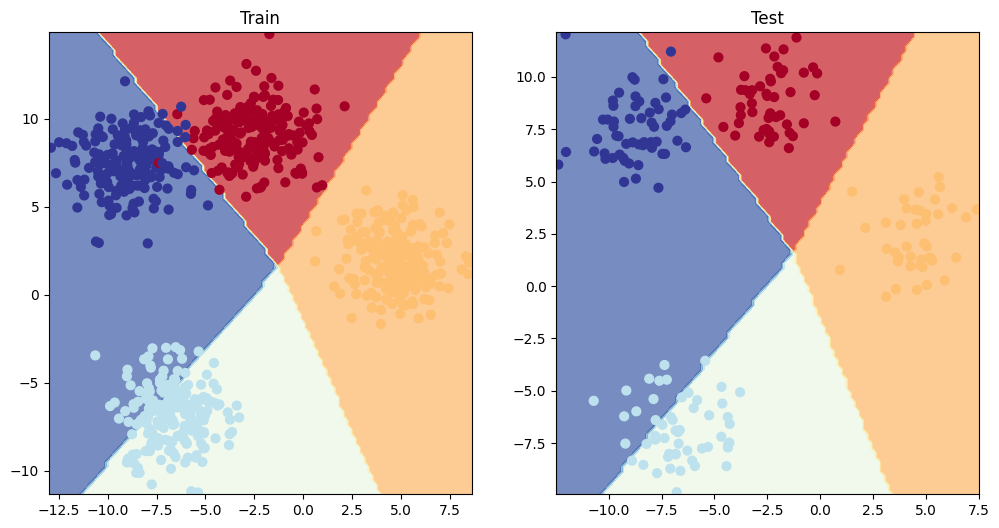

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_multi, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_multi, X_test, y_test)